# produce figure 1a - Cladogram and list of haplogroup indices

In [7]:
#manually grab the mvncalls (as they haven't been PR'd) and weave them
#generate the dendrogram and use the code from ag1000g fig5 to get the indices of haplogroup haplotypes.

In [137]:
%run setup.ipynb
%matplotlib inline
import hapclust

### data set up 

In [24]:
# obtain data from unphased callset - only needed for variant annotations
callset = phase1_ar31.callset
pos_all = allel.SortedIndex(callset['2L/variants/POS'])
ann_all = callset['2L/variants/ANN'][:][['Annotation', 'HGVS_p']]

In [12]:
# setup haplotype data
callset_phased = phase1_ar31.callset_phased
genotypes_phased = allel.GenotypeDaskArray(callset_phased['2L/calldata/genotype'])
pos_phased = allel.SortedIndex(callset_phased['2L/variants/POS'])
genotypes_phased.shape, pos_phased.shape

((8296600, 773, 2), (8296600,))

In [13]:
pos_kdr_s = 2422651
pos_kdr_f = 2422652

In [14]:
# define region we're going to analyse
loc_region = pos_phased.locate_range(0, 4000000)
pos_phased_region = pos_phased[loc_region]
pos_phased_region

0,1,2,3,4,...,163958,163959,163960,163961,163962
44688,44691,44732,44736,44756,...,3997372,3997373,3997378,3997381,3997386


In [15]:
# chop genotypes to region, remove colony parents (8 samples) and turn into haplotype array
gen_phased_region = genotypes_phased[loc_region][:, :-8].compute()
gen_phased_region.shape
# don't turn in .to_haplotypes() yet - might be easier to interleave new positions first, then turn whole lot into hap

(163963, 765, 2)

#### grab mvncalls
- DOES IT MAKE A DIFFERENCE WHAT FILE WE USE 50/100/200 - CHECK - TO DO!

In [16]:
#genotypes
mvn_200 = np.load('../data/phasing_extra_phase1.mvncall.200.npz')
call_mvn = mvn_200['calldata']
gen_mvn = allel.GenotypeArray(call_mvn['genotype'])

#positions
pos_mvn = allel.SortedIndex(mvn_200['variants']['POS'])
pos_mvn

0,1,2
2391228,2400071,2429745


#### weave

In [17]:
#concatenate old and new gen/pos arrays
haps_combined = np.concatenate([gen_phased_region, gen_mvn], axis=0)
pos_combined = np.concatenate([pos_phased_region, pos_mvn], axis=0)

In [18]:
#sort pos indices
idx_sorted =np.argsort(pos_combined)

In [19]:
#use sorted indices to re-order the combined arrays
haps_combined = allel.GenotypeArray(haps_combined[idx_sorted])
haps_combined.shape

(163966, 765, 2)

In [20]:
pos_combined = allel.SortedIndex(pos_combined[idx_sorted])
pos_combined.shape

(163966,)

In [21]:
#then turn into haplotype array...
haps = haps_combined.to_haplotypes()
haps

<HaplotypeArray shape=(163966, 1530) dtype=int8>
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
...
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0

#### tie in annotations

In [22]:
# locate the intersection with unphased callset - needed to tie in annotations
loc1, _ = pos_all.locate_intersection(pos_combined)
np.count_nonzero(loc1)

163966

In [30]:
ann_combined = ann_all[loc1]
ann_combined

array([(b'intergenic_region', b'.'), (b'intergenic_region', b'.'),
       (b'intergenic_region', b'.'), ...,
       (b'downstream_gene_variant', b'.'),
       (b'downstream_gene_variant', b'.'),
       (b'downstream_gene_variant', b'.')], 
      dtype=[('Annotation', 'S34'), ('HGVS_p', 'S14')])

In [31]:
collections.Counter(ann_combined['Annotation'])

Counter({b'3_prime_UTR_variant': 2941,
         b'5_prime_UTR_premature_start_codon_': 306,
         b'5_prime_UTR_variant': 1677,
         b'downstream_gene_variant': 18539,
         b'initiator_codon_variant': 3,
         b'intergenic_region': 54849,
         b'intragenic_variant': 48,
         b'intron_variant': 32362,
         b'missense_variant': 5808,
         b'missense_variant&splice_region_var': 70,
         b'splice_acceptor_variant&intron_var': 24,
         b'splice_donor_variant&intron_varian': 27,
         b'splice_region_variant': 36,
         b'splice_region_variant&intron_varia': 649,
         b'splice_region_variant&stop_retaine': 5,
         b'splice_region_variant&synonymous_v': 87,
         b'start_lost': 9,
         b'stop_gained': 37,
         b'stop_lost&splice_region_variant': 4,
         b'stop_retained_variant': 5,
         b'synonymous_variant': 8636,
         b'upstream_gene_variant': 37844})

In [32]:
# perform allele count - needed to locate singletons - NEED TO UP MAX ALLELE TO 2 - MULTI ALLELICS?
ac_combined = haps.count_alleles(max_allele=2)
ac_combined[:1]

,0,1,2
0,1529,1,0


### setup missense variation

In [33]:
# convenience, define the Vgsc gene region
region_vgsc = SeqFeature('2L', 2358158, 2431617, label='Vgsc')
region_vgsc

<SeqFeature 'Vgsc' 2L:2358158-2431617>

In [34]:
loc_vgsc = pos_combined.locate_range(region_vgsc.start, region_vgsc.end)
loc_vgsc

slice(24471, 26184, None)

In [35]:
haps_vgsc = haps[loc_vgsc]

In [37]:
ac_vgsc = haps_vgsc.count_alleles(max_allele=2)

In [38]:
ann_vgsc = ann_combined[loc_vgsc]

In [39]:
loc_vgsc_missense = (ann_vgsc['Annotation'] == b'missense_variant') & (ac_vgsc[:, 1] > 7)
np.count_nonzero(loc_vgsc_missense)

19

In [40]:
haps_vgsc_missense = haps_vgsc[loc_vgsc_missense]

In [41]:
lbl_vgsc_missense = [l[2:] for l in ann_vgsc[loc_vgsc_missense]['HGVS_p'].astype('U')]
lbl_vgsc_missense

['Arg254Lys',
 'Val402Leu',
 'Asp466His',
 'Met490Ile',
 'Thr791Met',
 'Leu995Ser',
 'Leu995Phe',
 'Ala1125Val',
 'Ile1527Thr',
 'Asn1570Tyr',
 'Glu1597Gly',
 'Ala1746Ser',
 'Val1853Ile',
 'Ile1868Thr',
 'Pro1874Ser',
 'Pro1874Leu',
 'Phe1920Ser',
 'Ala1934Val',
 'Ile1940Thr']

## split up haplotype data
Here we divide haplotype data up into two, with an "EHH" set containing no singletons and only neutral variants, which we'll use for analysis of haplotype sharing, and a "mut" set containing singletons and putatively non-neutral variants that we will use for analysis of mutations on shared haplotypes.

In [42]:
# define types of variants to include in EHH analysis - should be mostly neutral
loc_type_neutral = ((ann_combined['Annotation'] == b'intergenic_region') | 
                    (ann_combined['Annotation'] == b'intron_variant') |
                    (ann_combined['Annotation'] == b'downstream_gene_variant') |
                    (ann_combined['Annotation'] == b'upstream_gene_variant') |
                    (ann_combined['Annotation'] == b'synonymous_variant') |
                    (ann_combined['Annotation'] == b'3_prime_UTR_variant') |
                    (ann_combined['Annotation'] == b'5_prime_UTR_variant') 
                    )
np.count_nonzero(loc_type_neutral), loc_type_neutral.shape

(156848, (163966,))

In [64]:
# locate singletons - will exclude from EHH analysis
### results from the code AM used doesn't look right, try 
# loc_sgl = ac_combined.min(axis=1 & 2) == 1
# loc_nosgl = ac_combined.min(axis=1) > 1
# np.count_nonzero(loc_sgl), np.count_nonzero(loc_nosgl), loc_nosgl.shape

(1, 2, (163966,))

In [85]:
#maybe it's because we have more alleles now?
loc_sgl1 = ac_combined.is_singleton(allele=1)
loc_sgl2 = ac_combined.is_singleton(allele=0)
np.count_nonzero(loc_sgl1), np.count_nonzero(loc_sgl2)

(52130, 91)

In [86]:
#add the alleles together
loc_sgl = loc_sgl1+loc_sgl2
np.count_nonzero(loc_sgl)

52221

In [87]:
#it would seem that making the no singleton list should be as simple as reversing the loc_sgl list
loc_nosgl = [not b for b in loc_sgl]
np.count_nonzero(loc_nosgl)

111745

In [88]:
#as this totals our number of var
52221+111745

163966

In [84]:
#however, in AMs code they don't - FIND OUT WHY?
52221+111611

163832

In [89]:
# these are the variants to use for EHH
loc_ehh = loc_type_neutral & loc_nosgl
np.count_nonzero(loc_ehh), loc_ehh.shape

(107652, (163966,))

In [92]:
# these are the variants to use for mutational distance
#loc_mut = loc_sgl
# include non-neutral mutations
loc_mut = loc_sgl | ~loc_type_neutral
np.count_nonzero(loc_mut), loc_mut.shape

(56314, (163966,))

In [95]:
haps_mut = haps[loc_mut]
pos_mut = pos_combined[loc_mut]

In [96]:
haps_ehh = haps[loc_ehh]
pos_ehh = pos_combined[loc_ehh]

In [99]:
#check
pos_mut.locate_key(pos_kdr_s)

10212

In [98]:
pos_mut.locate_key(pos_kdr_f)

10213

In [103]:
# read in haplotype metadata to get population
df_haplotypes = phase1_ar31.df_haplotypes
df_haplotypes = df_haplotypes[df_haplotypes.population != 'colony']
df_haplotypes.head()

,label,ox_code,population,label_aug,country,region,sex,m_s,kt_2la,kt_2rb
index,,,,,,,,,,
0,AB0085-Ca,AB0085-C,BFS,"AB0085-Ca [Burkina Faso, Pala, S, F]",Burkina Faso,Pala,F,S,2.0,2.0
1,AB0085-Cb,AB0085-C,BFS,"AB0085-Cb [Burkina Faso, Pala, S, F]",Burkina Faso,Pala,F,S,2.0,2.0
2,AB0087-Ca,AB0087-C,BFM,"AB0087-Ca [Burkina Faso, Bana, M, F]",Burkina Faso,Bana,F,M,2.0,1.0
3,AB0087-Cb,AB0087-C,BFM,"AB0087-Cb [Burkina Faso, Bana, M, F]",Burkina Faso,Bana,F,M,2.0,1.0
4,AB0088-Ca,AB0088-C,BFM,"AB0088-Ca [Burkina Faso, Bana, M, F]",Burkina Faso,Bana,F,M,2.0,0.0


## split flanks
split haplotype data into L/R flanks on kdr position

In [104]:
core_pos = pos_kdr_f

In [108]:
# split the EHH dataset
dist_ehh_right, dist_ehh_left, haps_ehh_right, haps_ehh_left = hapclust.split_flanks(haps_ehh, pos_ehh, core_pos)

In [109]:
# these give the distance from the core position to each downstream variant, moving away from the core
dist_ehh_right

array([     45,     255,     258, ..., 1574721, 1574726, 1574734], dtype=int32)

In [110]:
dist_ehh_right.shape, dist_ehh_left.shape

((91862,), (15790,))

In [111]:
dist_ehh_right.min(), dist_ehh_left.min()

(45, 108)

In [112]:
# split the mutations dataset
dist_mut_right, dist_mut_left, haps_mut_right, haps_mut_left = hapclust.split_flanks(haps_mut, pos_mut, core_pos)

In [113]:
dist_mut_right

array([      0,      82,     353, ..., 1574719, 1574720, 1574729], dtype=int32)

In [114]:
dist_mut_right.shape, dist_mut_left.shape

((46101,), (10213,))

In [115]:
dist_mut_right.min(), dist_mut_left.min()

(0, 1)

In [116]:
haps_ehh_left.shape, haps_ehh_right.shape, haps_mut_left.shape, haps_mut_right.shape

((15790, 1530), (91862, 1530), (10213, 1530), (46101, 1530))

In [119]:
is_accessible = phase1_ar3.accessibility['2L/is_accessible'][:]

## analyse maximal haplotype sharing ("nearest neighbour" analysis based on prefix sorting)
- nspl = neighbour sharing prefix length
- nspd = neighbour shared physical distance

In [120]:
idx_sorted_right, nspl_right, nspd_right, muts_right = hapclust.neighbour_haplotype_sharing(haps_ehh_right, haps_mut_right, dist_ehh_right, dist_mut_right)

In [121]:
idx_sorted_left, nspl_left, nspd_left, muts_left = hapclust.neighbour_haplotype_sharing(haps_ehh_left, haps_mut_left, dist_ehh_left, dist_mut_left)

In [122]:
nspl_right.min(), nspl_right.max()

(0, 76345)

In [123]:
nspd_right.min(), nspd_right.max()

(45, 1437047)

In [124]:
nspd_left.min(), nspd_left.max()

(108, 2377961)

In [125]:
muts_right.min(), muts_right.max()

(0, 14)

In [126]:
muts_left.min(), muts_left.max()

(0, 23)

In [127]:
# compute accessible lengths - needed for mutation analysis
nspd_right_accessible = hapclust.haplotype_accessible_length(nspd_right, core_pos=core_pos, is_accessible=is_accessible, flank='right')
nspd_left_accessible = hapclust.haplotype_accessible_length(nspd_left, core_pos=core_pos, is_accessible=is_accessible, flank='left')

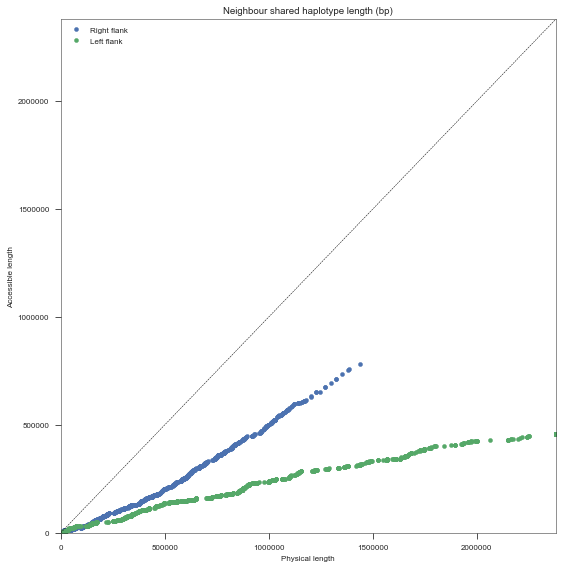

In [139]:
# get some diagnostics on accessibility on left versus right flanks
fig, ax = plt.subplots(figsize=(8, 8))
x = nspd_right
y = nspd_right_accessible
ax.plot(x, y, linestyle=' ', marker='o', markersize=4, label='Right flank')
x = nspd_left
y = nspd_left_accessible
ax.plot(x, y, linestyle=' ', marker='o', markersize=4, label='Left flank')
ax.set_xlabel('Physical length')
ax.set_ylabel('Accessible length')
lim = 0, x.max()
ax.set_xlim(*lim)
ax.set_ylim(*lim)
ax.plot(lim, lim, 'k--')
ax.legend()
ax.set_title('Neighbour shared haplotype length (bp)')
fig.tight_layout();

In [141]:
# 1 cM/Mb convert to M/bp
1 / (1e2 * 1e6)

1e-08

In [142]:
# assume constant recombination rate
rr_right = 1.5e-8
# adjust recombination rate on left flank (factor derived from pairwise analysis below)
rr_left = rr_right * 0.37

# assumed mutation rate
mu_right = 3.5e-9
# adjust mutation rate on left flank (factor derived from pairwise analysis below)
mu_left = mu_right * 0.61

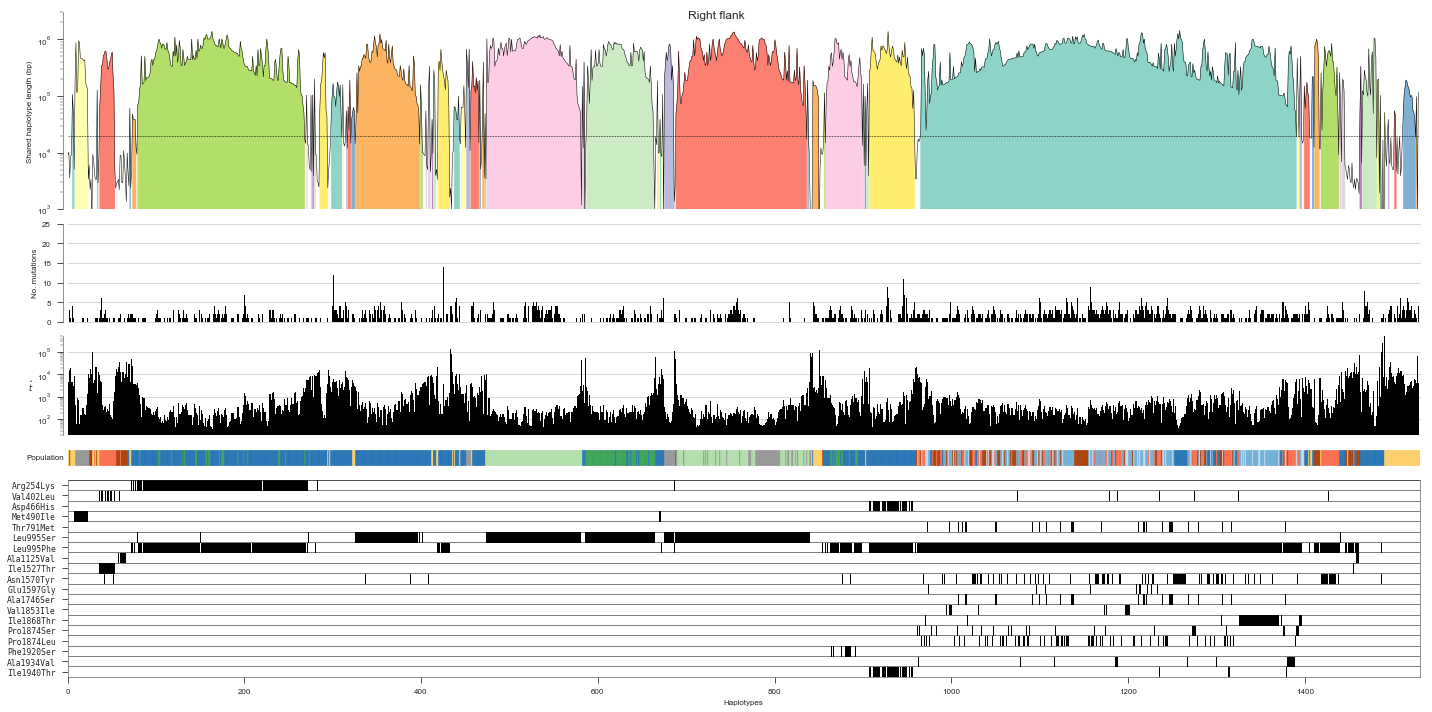

In [144]:
pops_right = df_haplotypes.population[idx_sorted_right]
pop_colors_right = [phase1_ar3.pop_colors[p] for p in pops_right]

fig = plt.figure(figsize=(20, 10))
hapclust.fig_neighbour_haplotype_sharing(nspd=nspd_right, 
                                         nspd_accessible=nspd_right_accessible,
                                         muts=muts_right, 
                                         haps_display=haps_vgsc_missense[:, idx_sorted_right],
                                         haps_display_vlbl=lbl_vgsc_missense,
                                         pop_colors=pop_colors_right,
                                         nspd_cut=2e4,
                                         nspd_ylim=(1e3, 3e6),
                                         that_ylim=(2e1, 5e5),
                                         muts_ylim=(0, 25),
                                         mu=mu_right, rr=rr_right,
                                         fig=fig)
fig.suptitle('Right flank');